<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Funcionales en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Homework 03 - Diffusion Maps</div><br>
    <div style="font-size: large">José Antonio Álvarez Ocete</div>
    <div style="font-size: large">Francisco Javier Saez Maldonado</div><br></div><hr>
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [2]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used.

In [4]:
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import pairwise_distances
from sklearn.utils.extmath import svd_flip
from sklearn.gaussian_process.kernels import RBF as rbf_kernel
from typing import Callable, Optional, Union, Type
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.datasets import make_blobs, make_swiss_roll, make_s_curve

from mpl_toolkits.mplot3d import Axes3D

matplotlib.rc('figure', figsize=(15, 5))

seed = 123
my_cmap = plt.cm.Spectral

# Introduction

This practical assignment is about implementing the manifold learning method **Diffusion Maps**, following the *scikit-learn* template for manifold learning algorithms.

We will design two main functions: one for training the algorithm, obtaining the affinity matrix and the embedded coordinates, and a second one for extending these coordinates for new patterns.

# Requirements

The objective of this assignment is to complete the class DM sketched below, which should contain at least the following methods.

`__init__(self, sigma, n_components, step=1, alpha=1)`

* This is the construction method for the class, with the following parameters:
    * `sigma`: Kernel parameter for the Gaussian kernel.
    * `n_components`: dimension of the embedding.
    * `step`: step in the Markov Chain.
    * `alpha`: density influence. It should take a value in `[0,1]`.
* This method just store the parameters in the fields of the class, to be used when needed.

`fit(self, X, y=None)`

* This is the training method, the one that performs the Diffusion Maps algorithm. 

* This method should store the affinity matrix and also the eigenvectors to compute the transformation.

`fit_transform(self, X, y=None)`

* This method returns the embedding coordinates for the training data.
* It should also store the affinity matrix and the coordinates needed to compute the transformation (for example over new, unseen patterns).

`transform(self, X)`

* This method will obtain approximated coordinates for new, unseen data points. 
* It uses for this purpose the Nyström Formula.

## Some recommendations

* It should allow to fix all the DM possibilities (different steps, density normalization...). To allow a change in the kernel function could be also a nice idea.
* Implement all the auxiliary functions that you may need, for example, for deciding the best parameter values in each case.
* It could be a nice idea to offer a deterministic output, that do not depend on the sign of the eigenvectors.

# Implementation

<div class="qst">

* Complete the `DM` class below, satisfying the described requirements.

</div>

## Implementation details

##### Eigenvectors signs

In order to offer a deterministic output, once we compute the eigenvectors we use Sklearn's function `svd_flip()` to obtain a deterministic sign on these vectors. This will allow us to better compare experiment results.


##### Density normalization

The parameter $\alpha$ is used to apply *density normalization* to our affinity matrix $K$. This is a two step process:

1. Normalize the kernel matrix:

$$
    k_{ij}^{(\alpha)} = \frac{k_{ij}}{d_i^\alpha d_j^\alpha}
$$

2. Compute the normalized probability matrix using the recalculated distance values $d_i^{(\alpha)}$:

$$
    p_{ij}^{(\alpha)} = \frac{k_{ij}^{(\alpha)}}{d_i^{(\alpha)}}
$$

This normalization is applied inside the `_compute_probability_matrix()` function, which returns the normalized affinity matrix $K^{(\alpha)}$, the normalized probability matrix $P^{(\alpha)}$ and the normalized distancia matrix $D^{(\alpha)}$.

##### Nystrom formula

In order to implement Nystrom formula we need to compute the new kernel matrix $K(X', X)$, and the associated probability matrix. However, the probability matrix needs to be normalized using $D$, which required the following $4$ submatrices

$$
    K = \begin{pmatrix}
        K(X, X) & K(X, X') \\
        K(X', X) & K(X', X')
    \end{pmatrix}
$$

and not only $K(X', X)$. Since the affinity matrix $K(X, X)$ was already computed in the `fit()` step, only the matrices $K(X', X)$ and $K(X', X')$ are required, and the whole new affinity matrix is manully built.

From this new affinity matrix, the probability matrix (with its own regularization) is created using the method `_compute_probability_matrix()`. Finally, the new set of (column) eigenvectors is computed using Nystrom formula:

$$
    \psi_j(\mathbf x) = \frac{1}{\lambda_j} \sum_{i=0}^N P(\mathbf x, \mathbf x^{(i)}) \cdot \phi_j(\mathbf x^{(i)})
$$

where $\psi_j(\mathbf x)$ is the value of the $j$-th new eigenvector for the test sample $\mathbf x$, $\phi_j(\mathbf x^{(i)})$ is the value of the $j$-th original eigenvector for the $i$-th training sample. This formula can be vectorized as follows:

$$
    \psi_j = \frac{1}{\lambda_j} \langle P(\mathbf X', \mathbf X) \; , \; \phi_j \rangle
$$

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin


class DM(TransformerMixin, BaseEstimator):
    """
        Diffusion Maps.
    """

    def __init__(self,
                 kernel: Union[str, Callable[[
                     np.ndarray, np.ndarray], np.ndarray]] = 'rbf',
                 sigma: Union[str, float] = 'percentile',
                 n_components: int = 2,
                 step: int = 1,
                 alpha: float = 0.0,
                 percentile: float = 50):
        """
        Initializes the Difussion Map object
         ----------
        kernel : kernel function to compute affinity matrix. 
                Can be 'rbf', 'laplacian' or a callable
        sigma : Sigma to apply to the kernel
        n_components: number of components to keep after projection
        step: Number of steps of the markov chain
        alpha: Density normalization parameter
        percentile: percentile (0 to 100) used to compute sigma if needed

        Returns
        -------
        self : returns an instance of self.
        """
        # Assignment of the hyper-parameters
        self.sigma = sigma
        self.n_components = n_components
        self.step = step
        self.alpha = alpha
        self._kernel = kernel
        self.percentile = percentile

        # Raise variables
        self._fitted = False
        self._fixed_sigma = False

    def _determine_sigma(self):
        """
        Converts string sigma values to actual float sigma values
        """
        if self.sigma == 'median':
            self.sigma = np.percentile(pairwise_distances(self.X), 50)
        elif self.sigma == 'maximum':
            self.sigma = np.percentile(pairwise_distances(self.X), 100)
        elif self.sigma == 'percentile':
            self.sigma = np.percentile(
                pairwise_distances(self.X), self.percentile)

        self._fixed_sigma = True

    def _determine_kernel(self):
        """
        Converts kernel value to final kernel
        """
        if not self._fixed_sigma:
            raise ValueError("Sigma has not been fixed yet")

        if self._kernel in ['auto', 'rbf']:
            # Recall that this rbf_kernel is the one from
            # Gaussian procesess, which receives sigma as parameter
            self._kernel = rbf_kernel(self.sigma)

        elif self._kernel == 'laplacian':
            self._kernel = lambda X, y = None: laplacian_kernel(
                X, y, gamma=1/(2*self.sigma**2))

    def _compute_probability_matrix(self, K):
        # Compute the distance matrix and raise it to alpha
        D = np.sum(K, axis=1)**self.alpha

        # Apply density normalization
        K_alpha = K / D / D.T

        # Re-compute the distance matrix using the normalized K
        D_alpha = K_alpha.sum(axis=1).reshape(-1, 1)

        # Compute the probability matrix by dividing each row.
        P = K_alpha / D_alpha

        return P, D_alpha, K_alpha

    def fit(self, X, y=None):
        """
        Compute the embedding vectors for data X
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        self : returns an instance of self.
        """
        # Save data
        self.X = X

        # Determine sigma to use
        self._determine_sigma()
        self._determine_kernel()

        # Instantiate the kernel and compute the affinity matrix
        K = self._kernel(X, X)
        self._affinity_matrix = K

        # Compute affinity matrix applying density normalization
        P, D, K = self._compute_probability_matrix(K)

        # Compute stationary distribution
        pi = (D / np.sum(D)).reshape(-1, 1)

        # Compute the conjugate of the P matrix
        D_sqrt = np.sqrt(D)
        A = K / D_sqrt
        A = A / D_sqrt.T

        # Obtain the SVD decomposition of the conjugate matrix
        # Remember that eigenvecs has the eigen-vectors as its columns!
        eigenvecs, eigenvals, V = np.linalg.svd(A, full_matrices=True)

        # Make the eigenvector signs match the ones obtained from Sklearn
        eigenvecs, _ = svd_flip(eigenvecs, V)

        # Normalize eigenvectors
        eigenvecs = eigenvecs / np.sqrt(pi)

        # Remove first component, with eigenvalue 1
        # Recall that we are assuming that the eigenvals/vecs are sorted!
        # n_components + 1 since we are already not considering 1st position
        self.eigenvecs = eigenvecs[:, 1:self.n_components + 1]
        self.eigenvals = eigenvals[1:self.n_components + 1]

        # Update fitted state
        self._fitted = True
        return self

    def fit_transform(self, X, y=None):
        """Compute the embedding vectors for data X and transform X.
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """
        self.fit(X)
        return (self.eigenvals**self.step) * self.eigenvecs

    def _expand_affinity_matrix(self, X_prime):
        K_crossed = self._kernel(X_prime, self.X)
        K_prime = self._kernel(X_prime, X_prime)
        K_1 = np.vstack([self._affinity_matrix, K_crossed])
        K_2 = np.vstack([K_crossed.T, K_prime])
        return np.hstack([K_1, K_2])

    def transform(self, X):
        """Transform X.
        This function is implemented using the Nyström formula.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features).
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """

        if not self._fitted:
            raise ValueError(' The model has not been fitted yet. Aborting.')
        # Compute the extended affinity matrix
        K_prime = self._expand_affinity_matrix(X)

        # Compute the extended probability matrix
        P_prime, _, _ = self._compute_probability_matrix(K_prime)

        # Extract P(X', X) from the whole P_prime
        P_crossed = P_prime[len(self.X):, :len(self.X)]

        # Iterate through the eigenvectors (stored as columns) to
        # obtain the new eigenvectors. Finally, store them as columns.
        new_eigenvecs = np.array([
            1.0 / lamb * P_crossed @ v.T
            for v, lamb in zip(self.eigenvecs.T, self.eigenvals)
        ]).T

        return new_eigenvecs

We create two functions to plot scatters in $2D$ and $3D$, with the only purpose of having a cleaner code in the following cells.

In [8]:
def scatter_2D(X, y, title="", equal_axis = False):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
    if equal_axis:
        ax.axis('equal')
    ax.set_title(title)
    plt.show()

def scatter_3D(X, y, title=""):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=my_cmap)
    ax.set_title(title)
    plt.show()

As a very first experiment, let us compare our class with the implementation of `Sklearn`. This library does **not** have an implementation of Difussion Maps. We can, however, chose $T = \alpha = 0$ and execute both tests, and the result should be the same if we use the same $\sigma$. Recall that, since `SpectralEmbedding` receives $\gamma$ instead of $\sigma$ as the parameter for the `rbf` kernel, we have to do the conversion $\gamma = \frac{1}{2\sigma^2}$ .

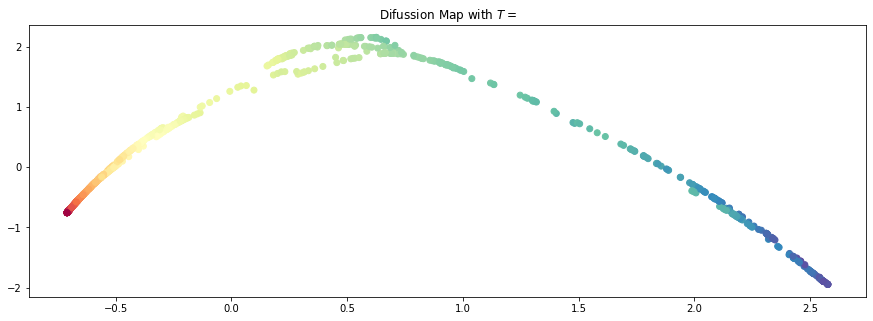

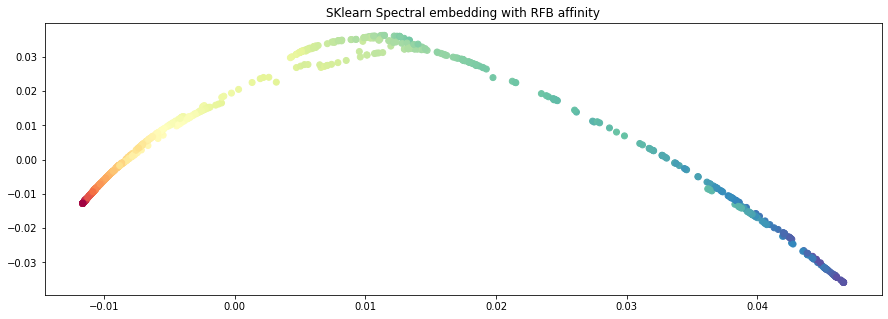

In [14]:
N = 1000
X, color = make_swiss_roll(N, random_state=seed)

dm = DM(n_components=2, sigma= 1.0, step=0, alpha=0)
X_red = dm.fit_transform(X)

scatter_2D(X_red,color,title = "Difussion Map with $T = \alpha = 0$")

se = SpectralEmbedding(affinity='rbf', gamma=0.5)
X_red_sk = se.fit_transform(X)

scatter_2D(X_red_sk,color,title = "SKlearn Spectral embedding with RFB affinity")

As we can see, the results are quite similar, so we can state that our class is performing well.

# Experiments with DM

<div class="qst">

* Obtain some good embedded coordinates for the three training datasets specified below.
    
* Extend its coordinates for the new points.
    
</div>

It is known that Difussion Maps need the data to be standardized. We declare a scaler from `Sklearn` and we will use it  in the incoming cells (fitting it in each case).

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

## Dataset 1: two blobs

Let us begin with the simplest dataset. It consists of two blobs of points, each one corresponding to one class. We apply the standardization and compute both the `fit_transform` features and the approximation of the features given by the *Nystrom* formula.

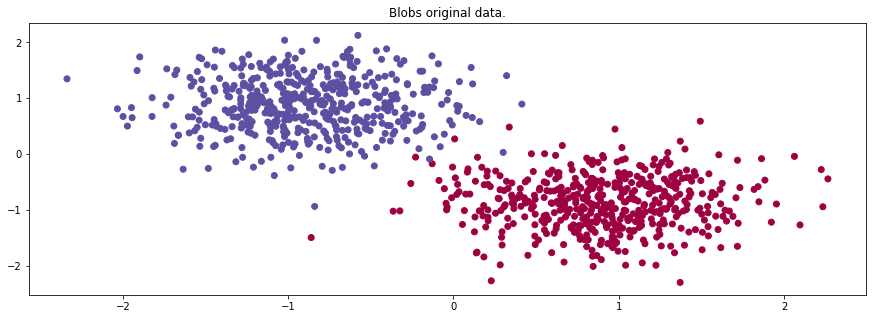

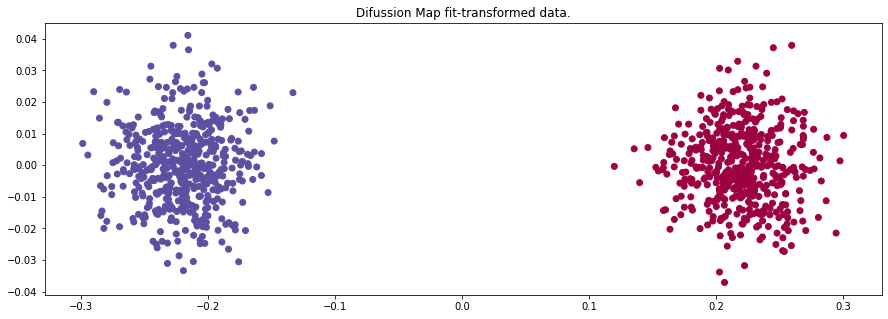

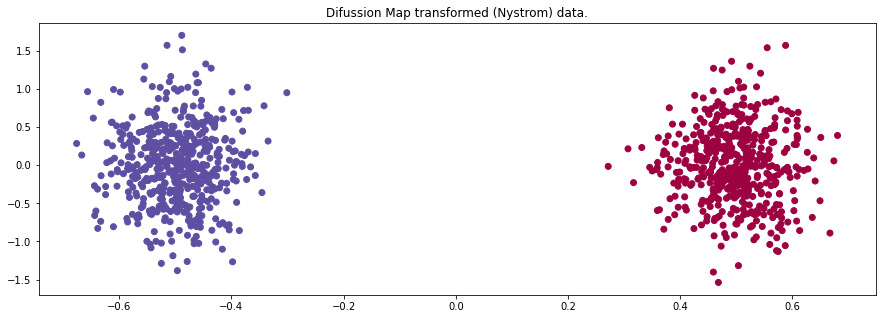

In [20]:
# Dataset creation
N = 1000
X, y = make_blobs(n_samples=N, n_features=50, centers=2,
                  cluster_std=3.0, random_state=seed)
y[y != 1] = -1

# Scale data and plot
X = scaler.fit_transform(X)
scatter_2D(X, y, title="Blobs original data.")

# Model definition
dm = DM()

# Transformation and plot
X_transformed = dm.fit_transform(X)
X_transformed_nystrom = dm.transform(X)
scatter_2D(X_transformed, y, title="Difussion Map fit-transformed data.")
scatter_2D(X_transformed_nystrom, y,
           title="Difussion Map transformed (Nystrom) data.")

Let us make a brief analysis on how $\sigma$ affects this dataset. We will plot the extracted features for different sigmas. We select very small sigma values and then increment them.

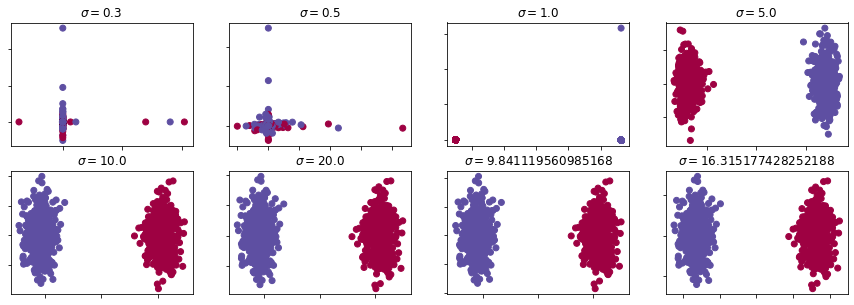

In [37]:
N = 1000
X, y = make_blobs(n_samples=N, n_features=50, centers=2,
                  cluster_std=3.0, random_state=seed)
y[y != 1] = -1
X = scaler.fit_transform(X)

sigmas = [0.3,0.5,1.0,5.0,10.0,20.0, 'median','maximum']
fig, axes = plt.subplots(2,4)
for i,sigma in enumerate(sigmas):
    dm = DM(sigma = sigma)
    X_iter = dm.fit_transform(X)
    axes[i//4][i%4].scatter(X_iter[:, 0], X_iter[:, 1], c=y, cmap=my_cmap)
    axes[i//4][i%4].set_title("$\sigma = ${}".format(str(dm.sigma)))
    axes[i//4][i%4].set_yticklabels([])
    axes[i//4][i%4].set_xticklabels([])



It can be observed that when we use very small sigma values, the projections *lie* on the $x = y = 0$ axis. When we increase this value to *medium* (consider medium $1.0$ to $5.0$ values), our algorithm disperses the points from the axis. Lastly, it is shown how this dataset benefits from **larger** sigma values.

Let us see how the **Nystrom** approximation performs on the new data.

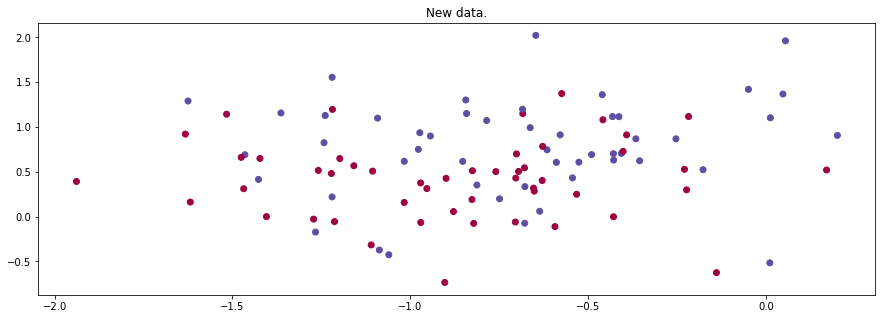

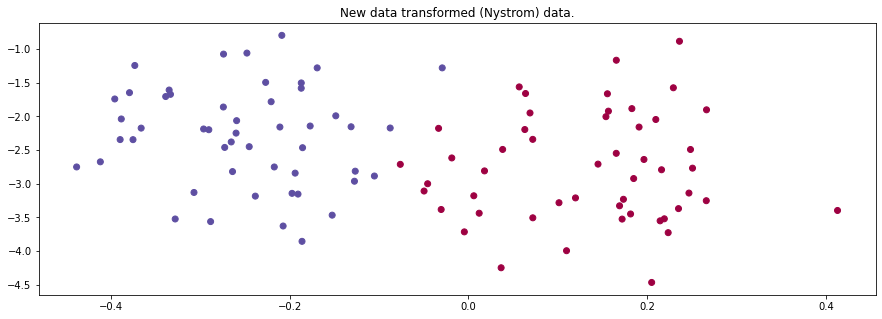

In [149]:
# Create new data
N_new = 100
X_new, y_new = make_blobs(n_samples=N_new, n_features=50, centers=2,
                          cluster_std=3.0, random_state=seed+1)

# Transform new data
X_new = scaler.transform(X_new)
X_new_transformed = dm.transform(X_new)

scatter_2D(X_new, y_new,
           title="New data.")
scatter_2D(X_new_transformed, y_new,
           title="New data transformed (Nystrom) data.")

As we can see, our algorithm has completely separated both blobs.

### Influence of $\alpha$ in blobs

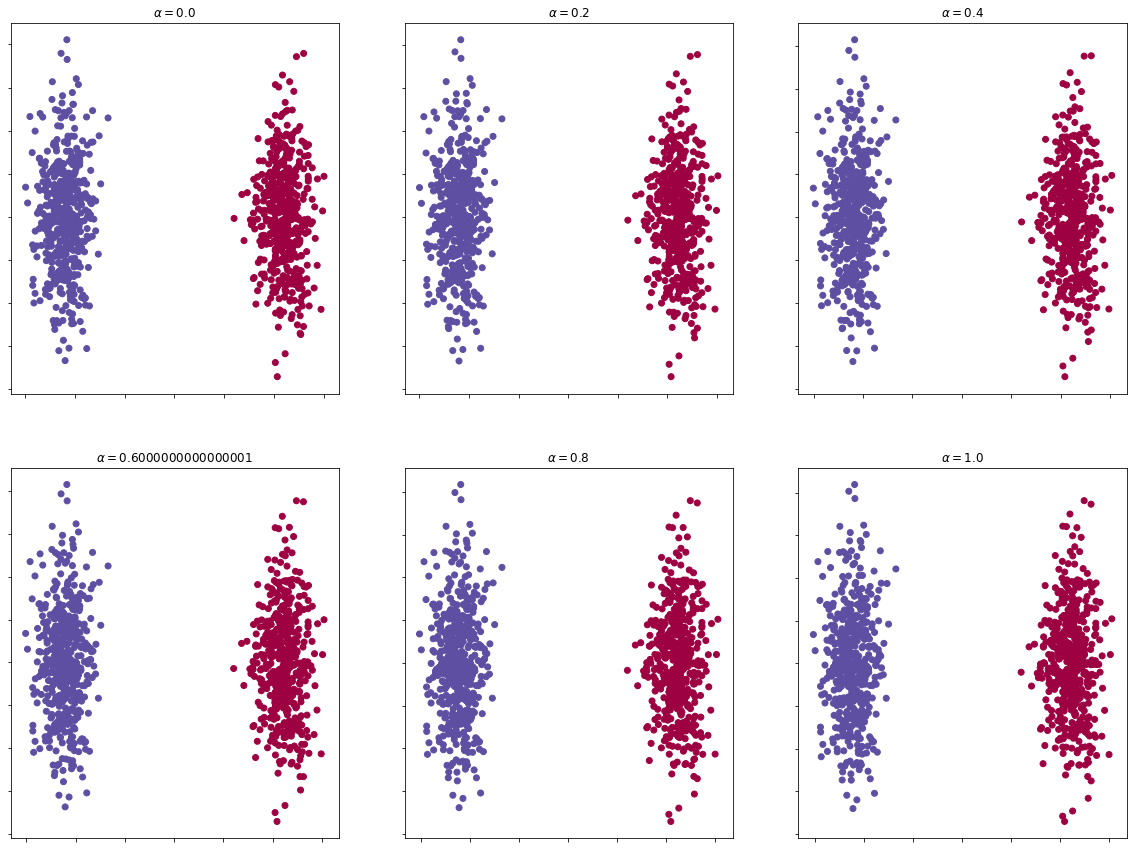

In [84]:
N = 1000
X, y = make_blobs(n_samples=N, n_features=50, centers=2,
                  cluster_std=3.0, random_state=seed)
y[y != 1] = -1
X = scaler.fit_transform(X)

alphas = np.arange(0.0,1.01,0.2)
fig, axes = plt.subplots(2,3, figsize = (20,15))
for i,alpha in enumerate(alphas):
    dm = DM(sigma = 'median', alpha = alpha)
    X_iter = dm.fit_transform(X)
    axes[i//3][i%3].scatter(X_iter[:, 0], X_iter[:, 1], c=y, cmap=my_cmap)
    axes[i//3][i%3].set_title(r"$\alpha = ${}".format(alpha))
    axes[i//3][i%3].set_yticklabels([])
    axes[i//3][i%3].set_xticklabels([])

In this case, we observe that the parameter $\alpha$ has no influence on the embedding obtained. This enforces the idea that the dataset is *simple*.

## Dataset 2: the swiss roll

We will repeat the previous process using the **Swill Roll** dataset.

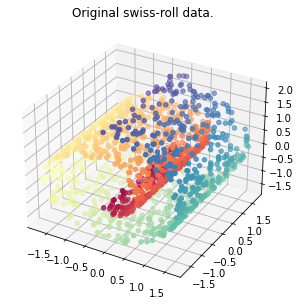

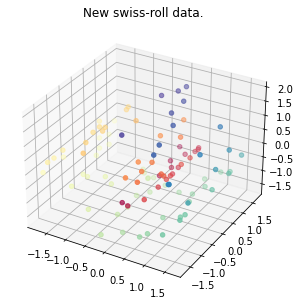

In [33]:
# Create Swiss Roll data
N = 1500
X, color = make_swiss_roll(n_samples=N, random_state=seed)
X = scaler.fit_transform(X)

# Create new (test) data
N_new = 100
X_new, color_new = make_swiss_roll(n_samples=N_new, random_state=seed+1)
X_new = scaler.transform(X_new)

scatter_3D(X, color, title="Original swiss-roll data.")
scatter_3D(X_new, color_new, title="New swiss-roll data.")

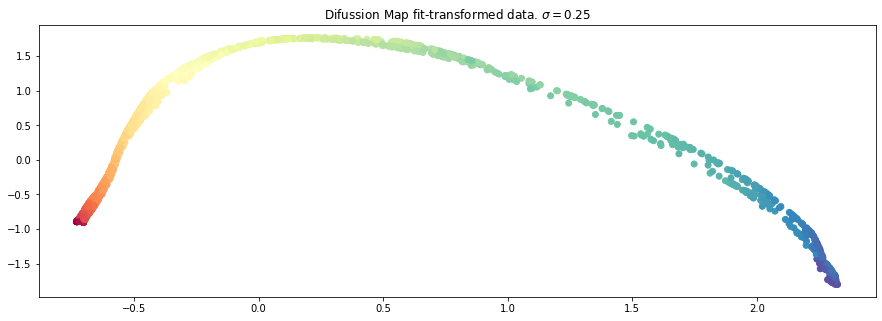

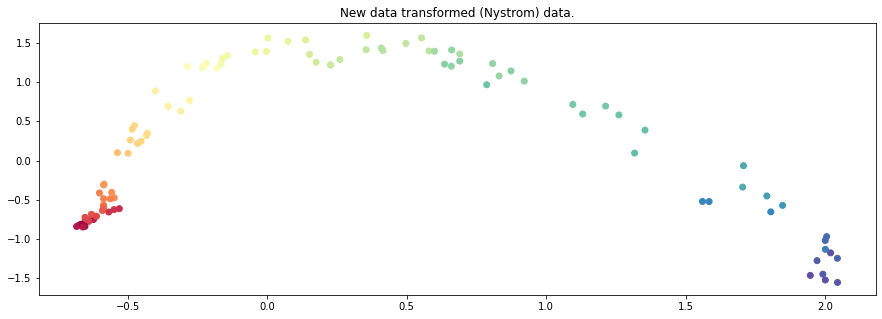

In [36]:
# Model definition
dm = DM(sigma=0.25, alpha=0)

# Transformation and plot
X_transformed = dm.fit_transform(X)
scatter_2D(X_transformed, color, title="Difussion Map fit-transformed data. $\sigma = ${}".format(dm.sigma))

# DM-transform new data
X_new_transformed = dm.transform(X_new)
scatter_2D(X_new_transformed, color_new,
           title="New data transformed (Nystrom) data.")

After a long time searching for an appropiate $\sigma$ parameter, we have found that $\sigma = 0.25$ (which is quite smaller than in the previous case) almost completely unrolls this dataset. In terms of linear separability, we have obtained a much better set.

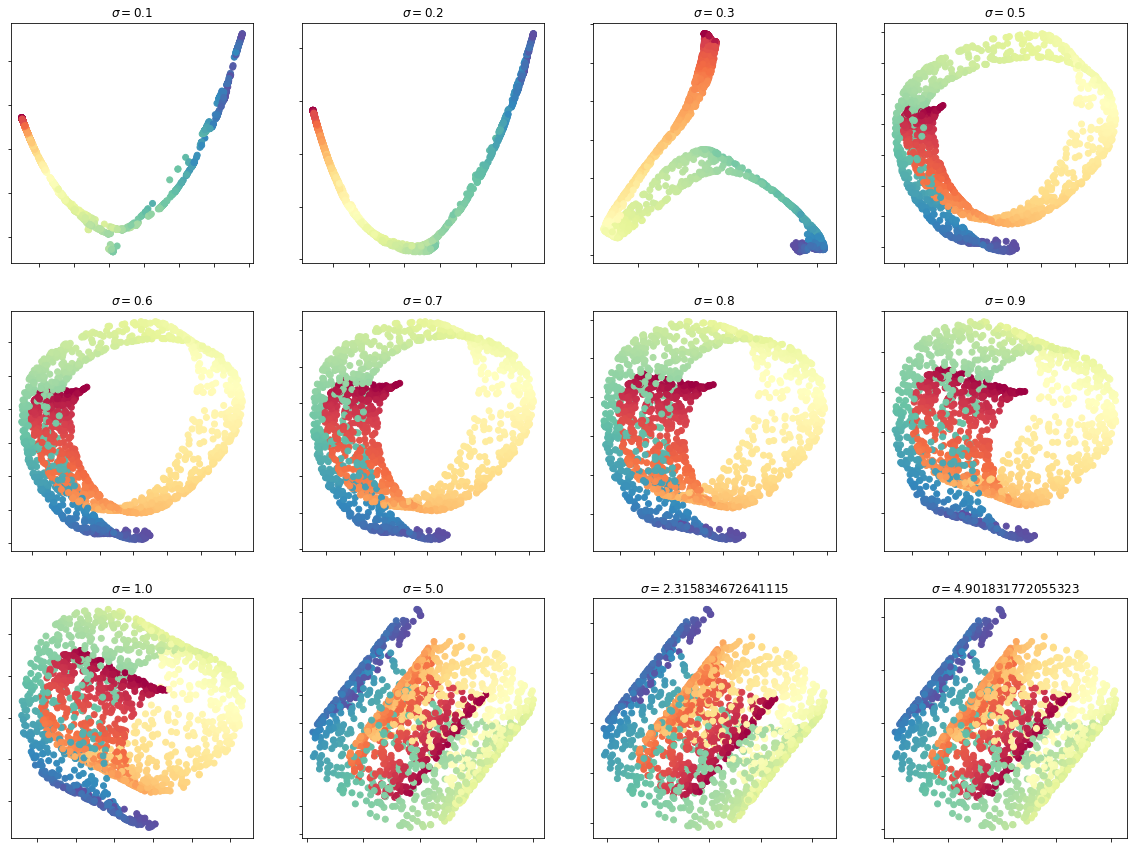

In [55]:
# Create Swiss Roll data
N = 1500
X, color = make_swiss_roll(n_samples=N, random_state=seed)
X = scaler.fit_transform(X)

sigmas = [0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,1.0,5.0,'median','maximum']
fig, axes = plt.subplots(3,4, figsize = (20,15))
for i,sigma in enumerate(sigmas):
    dm = DM(sigma = sigma, alpha = 0.0)
    X_iter = dm.fit_transform(X)
    axes[i//4][i%4].scatter(X_iter[:, 0], X_iter[:, 1], c=color, cmap=my_cmap)
    axes[i//4][i%4].set_title("$\sigma = ${}".format(str(dm.sigma)))
    axes[i//4][i%4].set_yticklabels([])
    axes[i//4][i%4].set_xticklabels([])


As we can see, in this case we need much smaller $\sigma$ values in order to obtain a better unrolling in our dataset. When $\sigma > 1$, the transformed data resembles the original data but in $2$ dimensions, which is clearly a really bad unrolling of our manifold. If we observe the values in the interval $[0.5,1.0]$, we observe how the projections *slowly enroll to the original form* of the manifold.


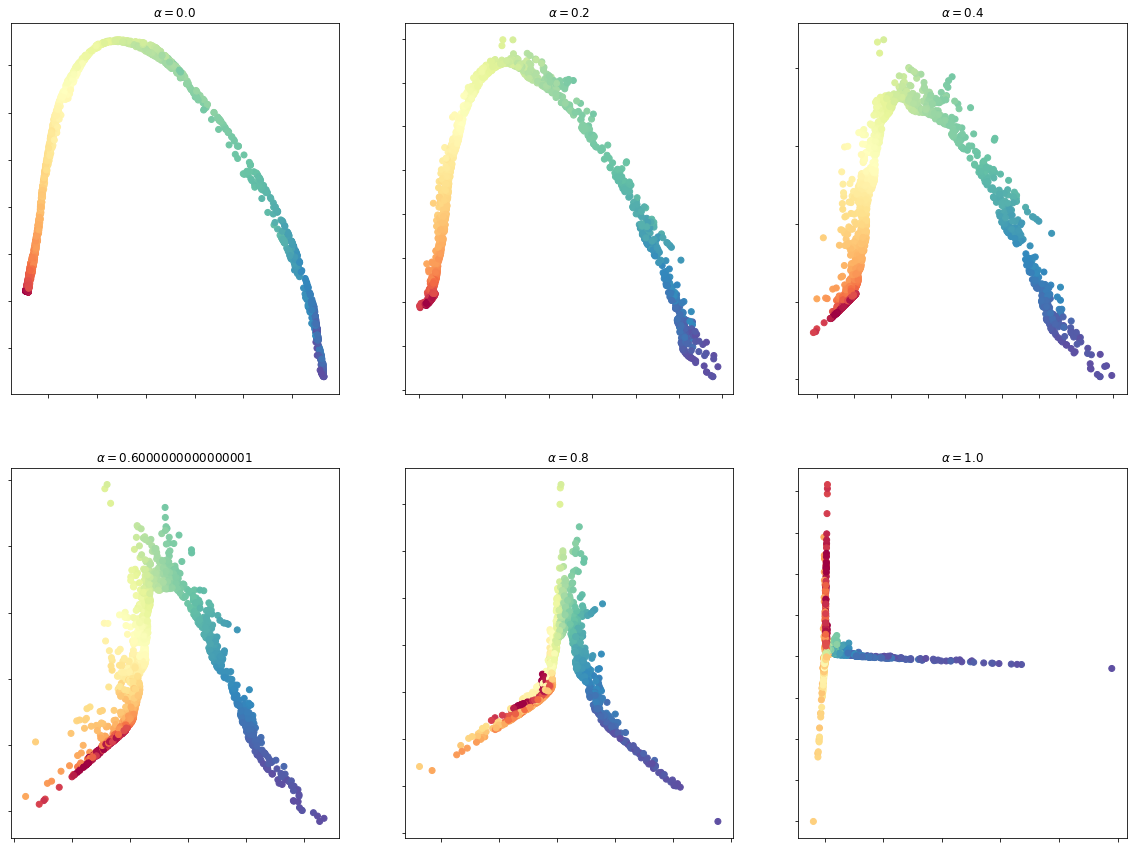

In [57]:
# Create Swiss Roll data
N = 1500
X, color = make_swiss_roll(n_samples=N, random_state=seed)
X = scaler.fit_transform(X)

alphas = np.arange(0.0,1.01,0.2)
fig, axes = plt.subplots(2,3, figsize = (20,15))
for i,alpha in enumerate(alphas):
    dm = DM(sigma = 0.25, alpha = alpha)
    X_iter = dm.fit_transform(X)
    axes[i//3][i%3].scatter(X_iter[:, 0], X_iter[:, 1], c=color, cmap=my_cmap)
    axes[i//3][i%3].set_title(r"$\alpha = ${}".format(alpha))
    axes[i//3][i%3].set_yticklabels([])
    axes[i//3][i%3].set_xticklabels([])


As we can observe, $\alpha$ has a great influence in the unrolling of the data. When $\alpha \to 1$, the data is gathered in axis, obtaining a much worse representation compared with the case $\alpha = 0$. This means that, in this case, $\mathbf{d}$ influences  how the diffusion coordinates capture the underlying geometry (unless $\mathbf{d}$ is uniform).

## Dataset 3: the S curve

Lastly, we have our **S curve** dataset. Let us plot the original and new data.

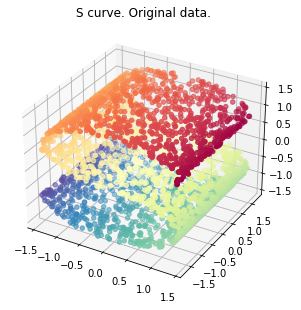

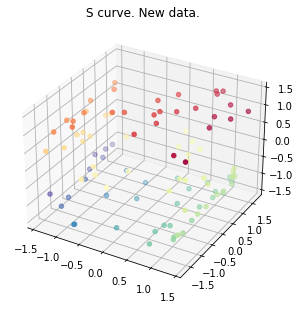

In [66]:
N = 3000
X, color = make_s_curve(N, random_state=seed)
X = scaler.fit_transform(X)

scatter_3D(X, color, title="S curve. Original data.")

N_new = 100
X_new, color_new = make_s_curve(N_new, random_state=seed+1)
X_new = scaler.transform(X_new)

scatter_3D(X_new, color_new, title="S curve. New data.")

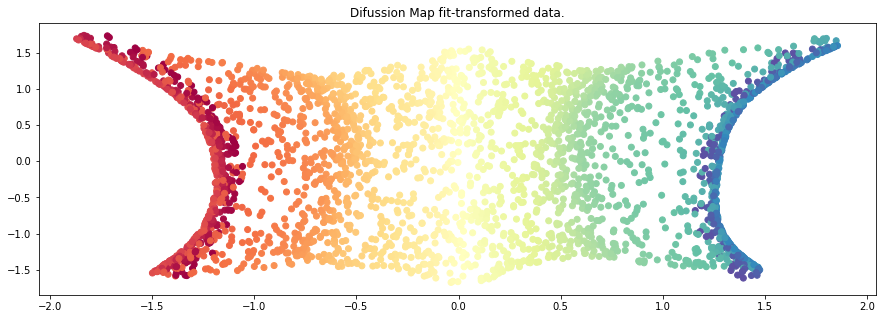

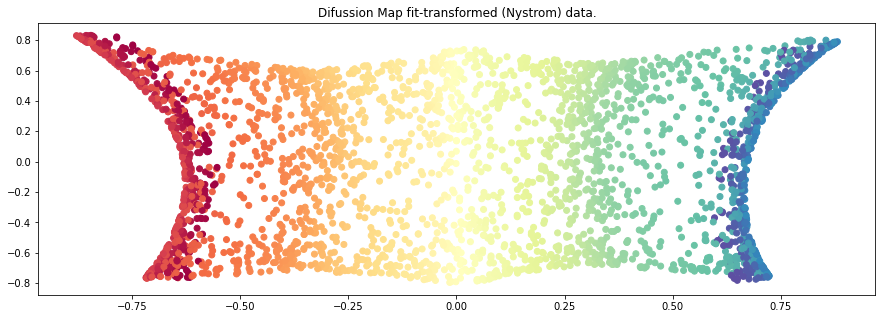

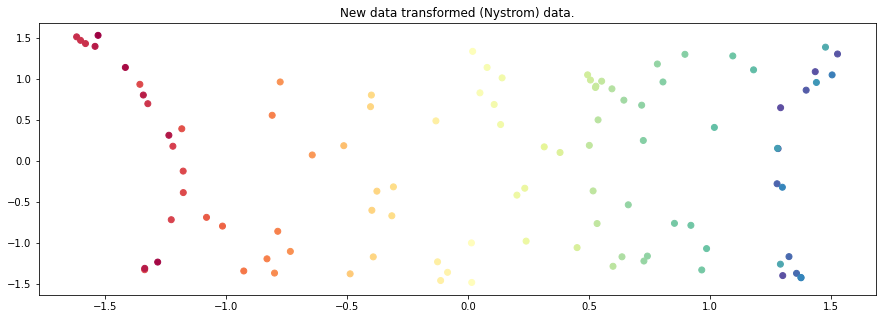

In [72]:
# Model definition
dm = DM(sigma=0.5, alpha=0.6)

# Transformation and plot
X_transformed = dm.fit_transform(X)
scatter_2D(X_transformed, color, title="Difussion Map fit-transformed data.")

X_transformed_2 = dm.transform(X)
scatter_2D(X_transformed_2, color, title="Difussion Map fit-transformed (Nystrom) data.")



X_new_transformed = dm.transform(X_new)

scatter_2D(X_new_transformed, color_new,
           title="New data transformed (Nystrom) data.")

As we can see, the used parameters in this dataset provide a *pretty good* unrolling of this particular dataset. Also, the embedding for the new points that is approximated by the Nystrom formula provides a quite sparse embedding of the data as we would desire.

### Influence of the $\sigma$ parameter

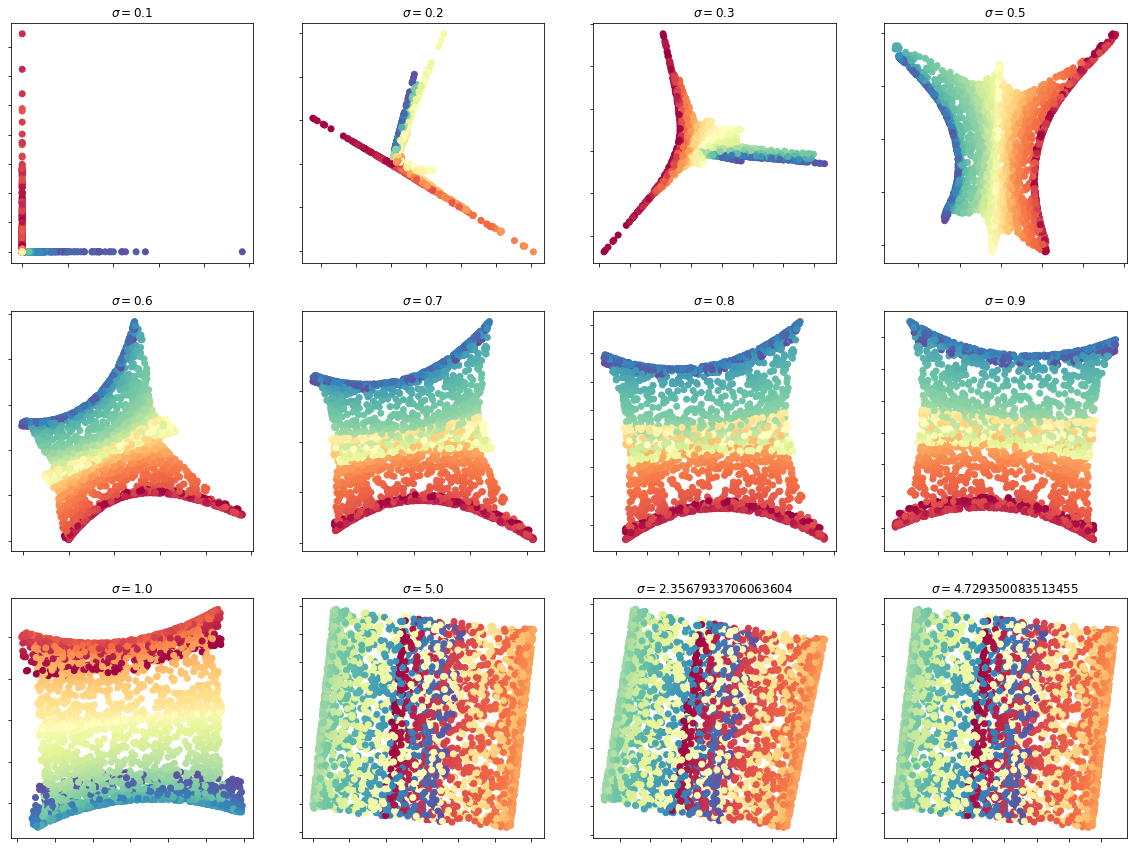

In [81]:
N = 3000
X, color = make_s_curve(N, random_state=seed)
X = scaler.fit_transform(X)

sigmas = [0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,1.0,5.0,'median','maximum']
fig, axes = plt.subplots(3,4, figsize = (20,15))
for i,sigma in enumerate(sigmas):
    dm = DM(sigma = sigma, alpha = 1.0)
    X_iter = dm.fit_transform(X)
    axes[i//4][i%4].scatter(X_iter[:, 0], X_iter[:, 1], c=color, cmap=my_cmap)
    axes[i//4][i%4].set_title("$\sigma = ${}".format(str(dm.sigma)))
    axes[i//4][i%4].set_yticklabels([])
    axes[i//4][i%4].set_xticklabels([])

We can observe that the optimal $\sigma$ parameter must be somewhere in between $0.5$ and $0.8$ As we increase the $\sigma$ parameter, the embedding losses the *separability* of the different original colors. Also, very low values for $\sigma$ causes the embedding of this particular dataset to be grouped near the axis or forming axis.

### Influence of the $\alpha$ parameter

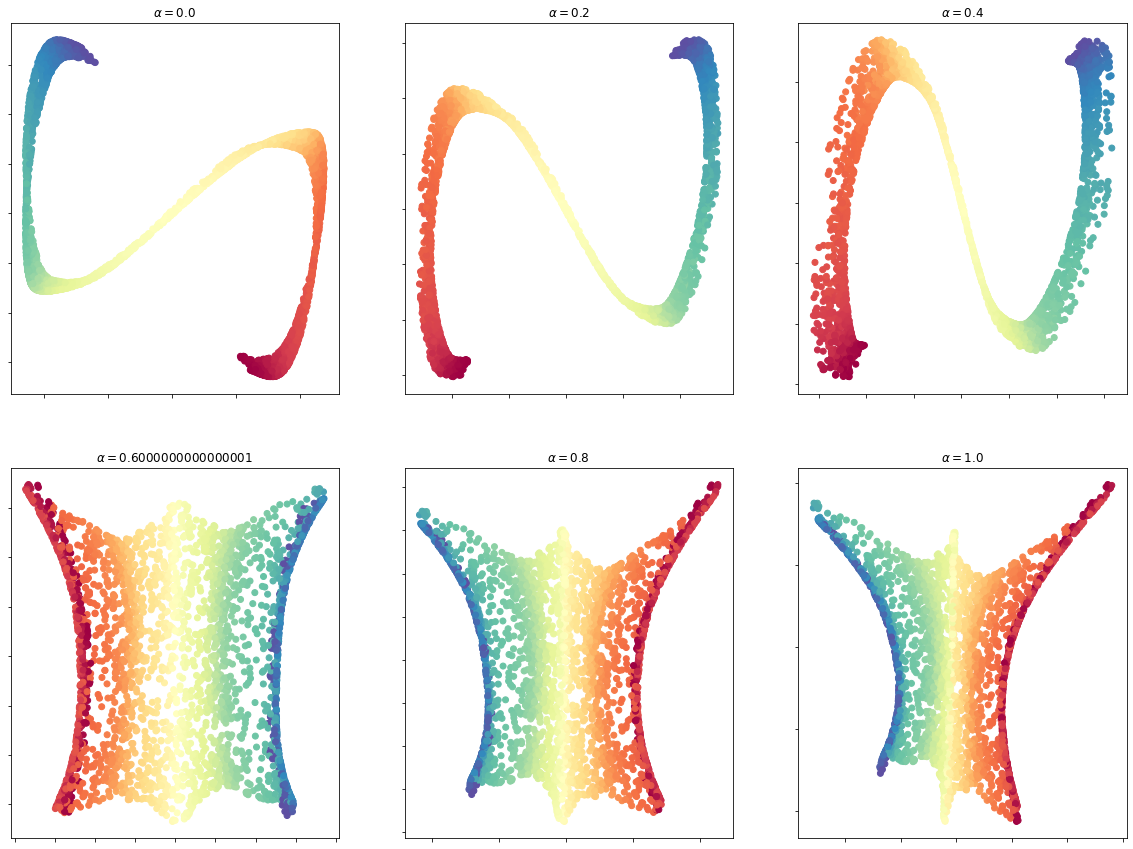

In [73]:
N = 3000
X, color = make_s_curve(N, random_state=seed)
X = scaler.fit_transform(X)

alphas = np.arange(0.0,1.01,0.2)
fig, axes = plt.subplots(2,3, figsize = (20,15))
for i,alpha in enumerate(alphas):
    dm = DM(sigma = 0.5, alpha = alpha)
    X_iter = dm.fit_transform(X)
    axes[i//3][i%3].scatter(X_iter[:, 0], X_iter[:, 1], c=color, cmap=my_cmap)
    axes[i//3][i%3].set_title(r"$\alpha = ${}".format(alpha))
    axes[i//3][i%3].set_yticklabels([])
    axes[i//3][i%3].set_xticklabels([])


Lastly, we have a look at the influence of the $\alpha$ parameter when we fix the (so chosen) *optimal sigma*, $\sigma = 0.5$. As we can appreciate, in this case we obtain a better unroll of the *S* manifold when we use an *intermediate* alpha, that is $\alpha \in [0.5,0.7]$. As we know, when $\alpha \to 1$, the DM captures the underlying geometry without interference from the sample’s density $\mathbf{d}$, so the difussion map is capturing the underlying geometry of our manifold well.

<div class="qst">

1. Do you consider that the embedding obtained is good for the previous datasets? Is it the expected one? Why?
    
    
2. How sensible is the method to its hyper-parameters? Specify the best values that you have found and the technique employed for it.
    * Check how much influence the sample density (you can vary N for each dataset).
    * Check what happens if the number of steps `steps` grows.
   
    
3. In your opinion, which is the main advantage and disadvantage of this method?
    
</div>

We will answer the questions one by one.

**First question.**

The conclusion for the first question is that, in general, the embedding obtained for the *blobs* dataset is quite good, and the embeddings for the *S* and *Swiss Roll* datasets are **good but not optimal**. As we know, ideally we would like to obtain an embedding that resembles a rectangle that has completely expanded the data. This happens (extremely, obtaining a very wide separation) in the *blobs* dataset case, and we are close to obtain the so called *blanket* in the two following datasets. Selecting the proper hyperparameters is not an easy task since we have no metric more than *the visual metric* to determine how well we are unrolling our data.

An alternative could be implementing the metrics presented in the paper **Diffusion Maps Parameters Selection Based on
Neighbourhood Preservation** by [Carlos M. Alaíz, Ángela Fernández and José R. Dorronsoro](https://www.esann.org/sites/default/files/proceedings/legacy/es2015-97.pdf) in order to perform a lesser *greedy* search.

**Second question.**

We have observed by the experiments varying the $\sigma$ and $\alpha$ parameters that the method is **extremely sentisive** to the hyperparameters selected. This fact, along with the fact (mentioned in the previous question) that we have not a real metric to determine how good our embedding is, turns the *hyperparameter search* in an exhausting task. The **followed technique** to find the best combination of hyperparameter was mainly the classic **trial-error** technique, plotting many embeddings and trying to look for the ones who are more similar to a *blanket* or a *line*. After all this process, we determine that the best hyperparameters found are:

- **Blobs**: $\sigma = 9.84$ and $\alpha$ has no influence.
- **Swiss Roll**: $\{\sigma = 0.25,\alpha = 0.0\}$.
- **S manifold**: $\{\sigma = 0.5,\alpha = 0.6\}$


Using this set of hyperparameters for each of the datasets, we would like to see the influence of the number of samples $N$ and then the steps taken $T$.


### Test using laplacian kernel


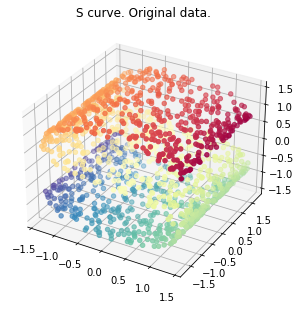

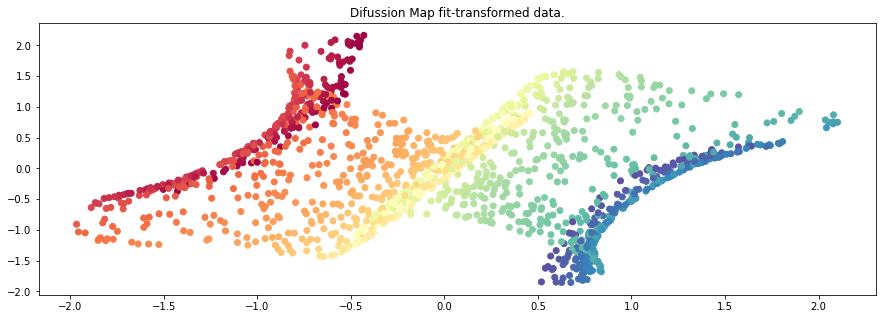

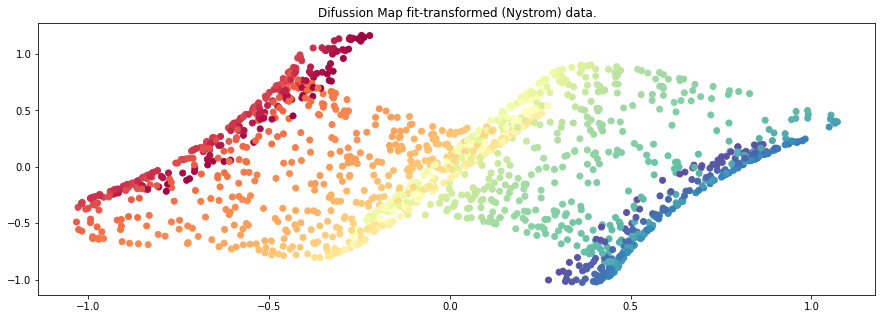

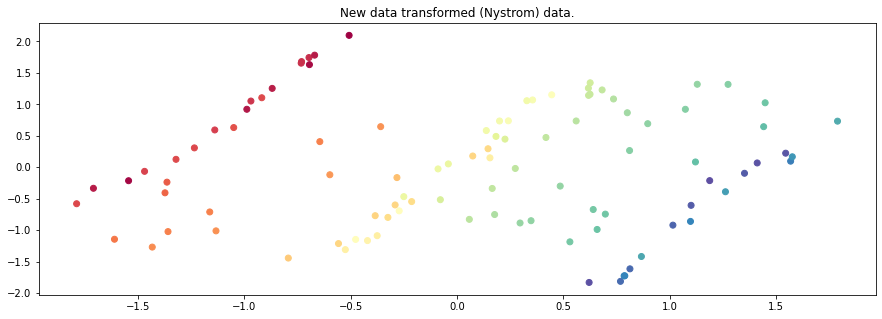

In [213]:
N = 1500
X, color = make_s_curve(N, random_state=seed)
X = scaler.fit_transform(X)

scatter_3D(X, color, title="S curve. Original data.")

# Model definition
dm = DM(kernel='laplacian', sigma=0.6, alpha=1)

# Transformation and plot
X_transformed = dm.fit_transform(X)
scatter_2D(X_transformed, color, title="Difussion Map fit-transformed data.")

X_transformed_2 = dm.transform(X)
scatter_2D(X_transformed_2, color, title="Difussion Map fit-transformed (Nystrom) data.")

N_new = 100
X_new, color_new = make_s_curve(N_new, random_state=seed+1)
X_new = scaler.transform(X_new)

X_new_transformed = dm.transform(X_new)

scatter_2D(X_new_transformed, color_new,
           title="New data transformed (Nystrom) data.")